In [ ]:
%pip install opencv-python
%pip install -r reuirements.txt
%pip install openpyxl
%pip install opencv-python face_recognition flask pandas
!pip install --upgrade --force-reinstall Pillow
!pip install facenet-pytorch
!pip install facenet-pytorch numpy sklearn
!pip install facenet-pytorch
%pip install mtcnn
%pip uninstall opencv-python-headless 

In [2]:
from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
from PIL import Image
import numpy as np
from facenet_pytorch import InceptionResnetV1
import torch
import torchvision.transforms as transforms


In [3]:
image = cv2.imread("train_image_1.jpg")


def detect_faces_mtcnn(image_path):
    # Load the image
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize MTCNN detector
    detector = MTCNN()
    faces = detector.detect_faces(rgb_image)

    # Draw rectangles around detected faces
    for face in faces:
        x, y, w, h = face['box']
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Detected Faces')
    plt.show()

# Example usage
detect_faces_mtcnn('train_image_1.jpg')

In [20]:
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

# Preprocess each detected face
def preprocess_face(face_boxes, image):
    cropped_faces = []
    
    for box in face_boxes:
        # Unpack bounding box coordinates (x1, y1, x2, y2)
        x1, y1, x2, y2 = box
        face = image[int(y1):int(y2), int(x1):int(x2)]  # Crop the face region
        
        # Convert the cropped face to PIL image for further processing
        face = Image.fromarray(face) 
        
        # Resize and normalize the face image (160x160)
        transform = transforms.Compose([
            transforms.Resize((160, 160)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
        ])
        
        cropped_faces.append(transform(face))  # Add to the list of cropped faces
    
    return cropped_faces


In [6]:
from facenet_pytorch import InceptionResnetV1
import torch

# Step 1: Initialize the face recognition model
model = InceptionResnetV1(pretrained='vggface2').eval()  # Load pre-trained model

# Step 2: Function to extract embeddings for each face
def extract_embeddings(face_image):
    # Ensure face_image is a tensor of shape (1, 3, 160, 160) normalized to [-1, 1]
    face_image = face_image.unsqueeze(0)  # Add batch dimension
    embeddings = model(face_image)  # Get 512-d embedding
    return embeddings.detach().numpy()

# Step 3: Loop through each cropped face to extract embeddings
def get_embeddings_for_faces(cropped_faces):
    embeddings_list = []
    for face in cropped_faces:
        # Extract embedding for each cropped face
        embedding = extract_embeddings(face)
        embeddings_list.append(embedding)
    return embeddings_list
def save_embeddings_to_dict(cropped_faces, face_ids):
    embeddings_dict = {}
    for idx, (face, face_id) in enumerate(zip(cropped_faces, face_ids)):
        # Extract embedding for each cropped face
        embedding = extract_embeddings(face)
        
        # Add the embedding to the dictionary with face_id as the key
        embeddings_dict[face_id] = embedding

    return embeddings_dict

In [8]:
from facenet_pytorch import MTCNN

# Step 1: Initialize the MTCNN model
mtcnn = MTCNN(keep_all=True)  # keep_all=True detects multiple faces

# Step 2: Load the image
image_path = 'train_image_1.jpg'  # Replace with your image path
image = cv2.imread(image_path)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Step 3: Perform face detection
boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)

# Step 4: Output results
print("Bounding Boxes:")
print(boxes)  # List of bounding boxes [x1, y1, x2, y2]
print("Confidence Scores:")
print(probs)  # Confidence scores for each face
print("Facial Landmarks:")
print(landmarks)  # Facial landmarks for each face

cropped_face = preprocess_face(boxes, rgb_image)  # Preprocess detected face
embeddings = get_embeddings_for_faces(cropped_face)

print(image_path)
print(embeddings)

Bounding Boxes:
[[394.54742431640625 106.82222747802734 597.5057983398438
  376.3800964355469]]
Confidence Scores:
[0.9992462396621704]
Facial Landmarks:
[[[456.18487548828125 215.13546752929688]
  [553.908203125 219.02073669433594]
  [501.26080322265625 268.80322265625]
  [450.1964111328125 307.23760986328125]
  [549.3529663085938 313.8839111328125]]]
train_image_1.jpg
[array([[ 0.00098292, -0.0247365 ,  0.03713832,  0.06195725, -0.05808968,
         0.08524794,  0.04450257, -0.01771352,  0.04403742, -0.00311051,
        -0.0053095 ,  0.03064304,  0.06750467,  0.12380038, -0.00647121,
        -0.07099663, -0.01075153,  0.04738329,  0.02821672,  0.00713993,
        -0.01774982,  0.03212099,  0.08006181,  0.02836354,  0.04937839,
         0.00146632, -0.06697658,  0.03415687, -0.00699389, -0.03626051,
         0.04355555,  0.04111683, -0.01778385, -0.05490145,  0.02342821,
         0.00190509,  0.01484527,  0.02186039,  0.03113549, -0.05666928,
         0.02920074, -0.01114146, -0.07147

In [9]:
cropped_faces = cropped_face  # List of cropped faces (each face should be a tensor)
face_ids = ['Person 1', 'Person 2']  # List of corresponding face IDs or names

# Step 4: Save embeddings in a dictionary
embeddings_dict = save_embeddings_to_dict(cropped_face, face_ids)

# Print the saved embeddings
for face_id, embedding in embeddings_dict.items():
    print(f"Embedding for {face_id}: {embedding}")

Embedding for Person 1: [[ 0.00098292 -0.0247365   0.03713832  0.06195725 -0.05808968  0.08524794
   0.04450257 -0.01771352  0.04403742 -0.00311051 -0.0053095   0.03064304
   0.06750467  0.12380038 -0.00647121 -0.07099663 -0.01075153  0.04738329
   0.02821672  0.00713993 -0.01774982  0.03212099  0.08006181  0.02836354
   0.04937839  0.00146632 -0.06697658  0.03415687 -0.00699389 -0.03626051
   0.04355555  0.04111683 -0.01778385 -0.05490145  0.02342821  0.00190509
   0.01484527  0.02186039  0.03113549 -0.05666928  0.02920074 -0.01114146
  -0.0714722  -0.02098707  0.02577231 -0.02544022  0.03127109 -0.0117694
   0.10061423 -0.0498558  -0.0248505  -0.02652129 -0.01956457  0.01592983
   0.00884448 -0.00702127 -0.01224307  0.01152011 -0.00904659 -0.03244657
  -0.00627258 -0.03522158  0.0079084  -0.01810283  0.03028606 -0.01187977
   0.0351256  -0.00646786  0.03924669  0.02362323 -0.00142185  0.09370279
  -0.03506034  0.01837651  0.06763943 -0.0436734   0.05166575 -0.01003946
  -0.04421866 -

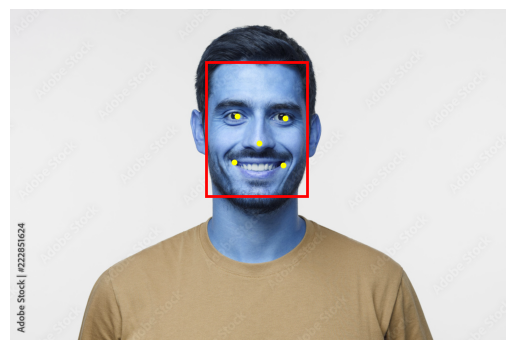

In [10]:
# Convert image to numpy array for visualization
image_np = np.array(image)

# Plot the image
plt.imshow(image_np)
ax = plt.gca()

# Plot the bounding boxes and landmarks
if boxes is not None:
    for box, landmark in zip(boxes, landmarks):
        # Draw bounding box
        x1, y1, x2, y2 = box
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', facecolor='none', lw=2))
        
        # Plot landmarks
        for point in landmark:
            plt.scatter(point[0], point[1], s=10,c='yellow')
plt.axis("off")
plt.show()


In [12]:
def euclidean_distance_numpy(embedding1, embedding2):
    return norm(embedding1 - embedding2)

In [13]:
# Function to calculate cosine similarity between two vectors
def cosine_similarity_manual(vec1, vec2):
    # Flatten vectors to 1D
    vec1 = vec1.flatten()
    vec2 = vec2.flatten()
    
    # Compute dot product
    dot_product = np.dot(vec1, vec2)
    
    # Compute the norms
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    # Compute and return the cosine similarity
    cosine_sim = dot_product / (norm_vec1 * norm_vec2)
    return cosine_sim

In [14]:
embeddings_dict.items()

dict_items([('Person 1', array([[ 0.00098292, -0.0247365 ,  0.03713832,  0.06195725, -0.05808968,
         0.08524794,  0.04450257, -0.01771352,  0.04403742, -0.00311051,
        -0.0053095 ,  0.03064304,  0.06750467,  0.12380038, -0.00647121,
        -0.07099663, -0.01075153,  0.04738329,  0.02821672,  0.00713993,
        -0.01774982,  0.03212099,  0.08006181,  0.02836354,  0.04937839,
         0.00146632, -0.06697658,  0.03415687, -0.00699389, -0.03626051,
         0.04355555,  0.04111683, -0.01778385, -0.05490145,  0.02342821,
         0.00190509,  0.01484527,  0.02186039,  0.03113549, -0.05666928,
         0.02920074, -0.01114146, -0.0714722 , -0.02098707,  0.02577231,
        -0.02544022,  0.03127109, -0.0117694 ,  0.10061423, -0.0498558 ,
        -0.0248505 , -0.02652129, -0.01956457,  0.01592983,  0.00884448,
        -0.00702127, -0.01224307,  0.01152011, -0.00904659, -0.03244657,
        -0.00627258, -0.03522158,  0.0079084 , -0.01810283,  0.03028606,
        -0.01187977,  0.03

In [15]:
from numpy.linalg import norm

def recognize_face(embedding, embeddings_dict, threshold=0.6):
    best_match = None
    best_score = -1  # Use a high value for Euclidean distance

    for name, known_embedding in embeddings_dict.items():
        # Compute Euclidean distance or cosine similarity
        distance = euclidean_distance_numpy(embedding,known_embedding)  # Euclidean distance
        
        if distance < best_score:
            best_score = distance
            best_match = name
    
    # Apply threshold for recognition
    if best_score < threshold:
        return best_match, best_score
    else:
        return "Unknown", best_score


In [16]:
# Step 1: Initialize the face recognition model
model = InceptionResnetV1(pretrained='vggface2').eval()  # Load pre-trained model

# Step 2: Extract embeddings for cropped face
def extract_embeddings(face_image):
    # Ensure face_image is a tensor of shape (1, 3, 160, 160) normalized to [-1, 1]
    face_image = face_image.unsqueeze(0)  # Add batch dimension
    embeddings = model(face_image)  # Get 512-d embedding
    return embeddings.detach().numpy()

In [17]:
def face_recognition_pipeline(image_path, embeddings_dict):
    # Detect faces using MTCNN
    #image = cv2.imread(image_path)
    #rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #detector = MTCNN()
    #faces = detector.detect_faces(rgb_image)
    boxes = detectImage(image_path)
    #box = face['box']  # Bounding box
    cropped_face = preprocess_face(boxes, rgb_image)  # Preprocess detected face
    #embedding = extract_embeddings(cropped_face)  # Extract embeddings
    embeddings = get_embeddings_for_faces(cropped_face)
    print(embeddings)
    # Recognize face
    name, score = recognize_face(embedding, embeddings_dict)
    print(f"Recognized {name} with confidence score: {score}")
    
    #for face in faces:
     #   box = face['box']  # Bounding box
      #  cropped_face = preprocess_face(box, rgb_image)  # Preprocess detected face
       # #embedding = extract_embeddings(cropped_face)  # Extract embeddings
        #embeddings = get_embeddings_for_faces(cropped_face)
        #
        # Recognize face
        #name, score = recognize_face(embedding, embeddings_dict)
        #print(f"Recognized {name} with confidence score: {score}")

In [21]:
def detectImage(image_path):
    # Step 1: Initialize the MTCNN model
    mtcnn = MTCNN(keep_all=True)  # keep_all=True detects multiple faces

    # Step 2: Load the image
    #image_path = 'train_image_1.jpg'  # Replace with your image path
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Step 3: Perform face detection
    boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)
    return boxes

In [22]:
face_recognition_pipeline('train_image_6.jpg', embeddings_dict)

[array([[-3.50496662e-03,  5.44877071e-03,  4.83198836e-02,
         3.11204977e-02, -6.39298111e-02,  8.20810348e-02,
         7.38702416e-02, -2.12838082e-03,  4.93949838e-02,
        -2.28065322e-03, -3.78914513e-02,  2.61656623e-02,
         3.76432873e-02,  1.30456224e-01, -2.13182606e-02,
        -8.08353201e-02, -4.50188527e-03,  1.88599266e-02,
         2.23689694e-02, -1.89391579e-02,  1.05550122e-02,
         2.00506416e-03,  5.95024899e-02,  3.34451571e-02,
         6.69406503e-02,  8.15048721e-03, -6.21100329e-02,
         3.82526331e-02,  1.10262900e-03, -4.32001650e-02,
         4.49887402e-02,  2.93190684e-02, -1.03647206e-02,
        -7.67737105e-02,  3.01288981e-02,  2.87243519e-02,
        -7.71454885e-04,  2.56084912e-02,  3.85955684e-02,
        -6.84704483e-02,  2.53447779e-02, -2.45641470e-02,
        -8.58519077e-02, -1.05717201e-02,  2.09768657e-02,
        -5.56138046e-02,  6.37180498e-03, -2.06913799e-02,
         1.28177226e-01, -6.28531426e-02, -1.55040016e-

# Image Capture Module

In [23]:
def test_camera():
    cap = cv2.VideoCapture(0)  # Use 0 for the default camera

    if not cap.isOpened():
        print("Camera not accessible!")
        return

    print("Camera accessed successfully. Press 'q' to quit.")
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame!")
            break

        # Save the frame to disk
        frame_name = f"frame_{frame_count}.jpg"
        cv2.imwrite(frame_name, frame)
        print(f"Frame saved as {frame_name}")
        frame_count += 1

        if frame_count == 1:  # Stop after 10 frames
            break

    cap.release()

# Run the test
test_camera()


Camera accessed successfully. Press 'q' to quit.
Frame saved as frame_0.jpg


In [25]:
face_recognition_pipeline('train_image_6.jpg', embeddings_dict)

[array([[-3.50496662e-03,  5.44877071e-03,  4.83198836e-02,
         3.11204977e-02, -6.39298111e-02,  8.20810348e-02,
         7.38702416e-02, -2.12838082e-03,  4.93949838e-02,
        -2.28065322e-03, -3.78914513e-02,  2.61656623e-02,
         3.76432873e-02,  1.30456224e-01, -2.13182606e-02,
        -8.08353201e-02, -4.50188527e-03,  1.88599266e-02,
         2.23689694e-02, -1.89391579e-02,  1.05550122e-02,
         2.00506416e-03,  5.95024899e-02,  3.34451571e-02,
         6.69406503e-02,  8.15048721e-03, -6.21100329e-02,
         3.82526331e-02,  1.10262900e-03, -4.32001650e-02,
         4.49887402e-02,  2.93190684e-02, -1.03647206e-02,
        -7.67737105e-02,  3.01288981e-02,  2.87243519e-02,
        -7.71454885e-04,  2.56084912e-02,  3.85955684e-02,
        -6.84704483e-02,  2.53447779e-02, -2.45641470e-02,
        -8.58519077e-02, -1.05717201e-02,  2.09768657e-02,
        -5.56138046e-02,  6.37180498e-03, -2.06913799e-02,
         1.28177226e-01, -6.28531426e-02, -1.55040016e-